# Tarea 2: Análisis de Discriminante Lineal

En esta tarea se utilizará el método de Análisis de Discriminante Lineal para poder clasificar correctamente, según las características de cada flor, el tipo de iris al que pertenece. 

## Datos

Primero cargamos la librería y visualizamos el Data Frame

In [5]:
library(datasets)
library(ggplot2)
library(dplyr)

In [6]:
data(iris)
str(iris)

'data.frame':	150 obs. of  5 variables:
 $ Sepal.Length: num  5.1 4.9 4.7 4.6 5 5.4 4.6 5 4.4 4.9 ...
 $ Sepal.Width : num  3.5 3 3.2 3.1 3.6 3.9 3.4 3.4 2.9 3.1 ...
 $ Petal.Length: num  1.4 1.4 1.3 1.5 1.4 1.7 1.4 1.5 1.4 1.5 ...
 $ Petal.Width : num  0.2 0.2 0.2 0.2 0.2 0.4 0.3 0.2 0.2 0.1 ...
 $ Species     : Factor w/ 3 levels "setosa","versicolor",..: 1 1 1 1 1 1 1 1 1 1 ...


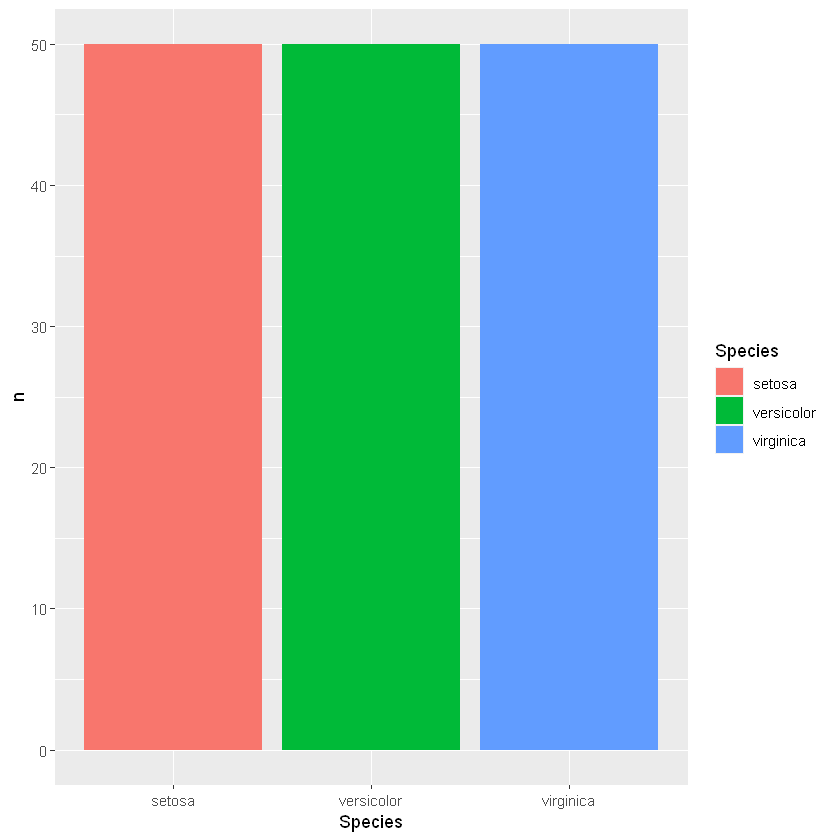

In [21]:
iris %>%
    group_by(Species) %>%
    count() %>%
    ggplot(aes(x=Species,y=n,fill=Species))+geom_col()

Podemos notar que tenemos 3 distintas especies de iris: setosa, versicolor, virginica. Se cuenta con 50 observaciones de cada una. 

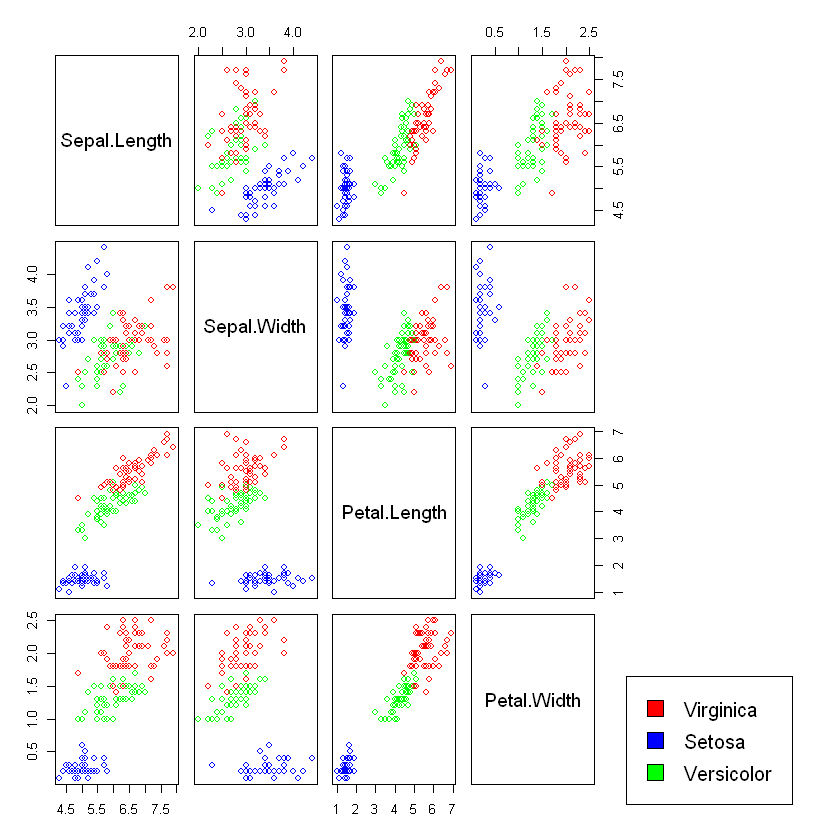

In [33]:
#Escogemos los colores para cada especie de iris
cols <- character(nrow(iris))
cols[iris$Species == "virginica"] <- "red"
cols[iris$Species == "setosa"] <- "blue"
cols[iris$Species == "versicolor"] <- "green"

# Hacemos todos los posibles scatter plots omitiendo la variable de Species
pairs(iris[,-5],col=cols,oma=c(3,3,3,15))  #El argumento de oma se agrega para que la leyenda no se encime con la gráfica
par(xpd = TRUE)
legend("bottomright",
c("Virginica","Setosa","Versicolor"),
fill=c("red","blue","green"))


Para ciertas parejas de datos, como por ejemplo _Sepal.Lenght_ y _Petal.Length_ , la división entre las especies es muy notoria. El par más problemático resulta ser _Sepal.Length_ y _Sepal.Width_ , pero fuera de esto se puede apreciar una clara separación dentro de cada gráfica de dispersión. 

## Funciones

En este apartado se muestran las funciones que se utilizarán para poder realizar el LDA. 

### Función apriori

In [12]:
apriori<-function(df,col,clase){
    # Calculamos N_k / N
    col <- df[,col]  #Primero obtienes la columna que quieres
    col<-col[col==clase] #Despues la filtras
    
    return(length(col)/nrow(df))
}

Prueba:

In [13]:
apriori(iris,'Species','setosa')

[1] 0.3333333

### Función media

In [208]:
media<-function(df,col,variables_indep,clase){
    #Primero obtenemos el data frame filtrado a la clase de interés
    filtro<-which(df[[col]]==clase) #Aquí estás filtrando de acuerdo a la clase
    df_filtrado<-df[filtro,] #Obtenemos el data frame filtrado
    
    #Ahora obtenemos las medias de las variables independientes de interés
    if(length(variables_indep)>1)
        medias<-colMeans(df_filtrado[,variables_indep])
    else
        medias<-mean(df_filtrado[,variables_indep])
        
    
    return(medias)
    
}


Prueba: 

In [210]:
media(iris,'Species',c('Sepal.Length','Sepal.Width','Petal.Length','Petal.Width'),'setosa')


Sepal.Length  Sepal.Width Petal.Length  Petal.Width 
       5.006        3.428        1.462        0.246

### Función varianza/covarainza

In [269]:
# IMPORTANTE: el parámetro de medias es una lista de vectores como la siguiente: 
# medias <- list(setosa=c(1,2,3,4), virginica=c(5,6,7,8), versicolor=c(21,32,11))



# Esta es una función auxiliar que calcula la varianza de cada clase (la sumatoria de adentro de la fórmula del PDF)

var_clase<-function(df,medias,clase){
    vec_media<-unlist(medias[clase],use.names=FALSE) #De la lista de medias, sacas y conviertes en vector la de la clase a usar
    B<-list(NULL)
    
    if(length(vec_media)==1){
        
        for(i in 1:length(df)){
            B[[i]]<-(as.numeric(df[i])-vec_media) %*% t(as.numeric(df[i])-vec_media)
        }

        suma<-B[[1]]

        for(i in 2:length(df)){
            suma<-suma+B[[i]]
        }
        
        res<-(1/(as.numeric(length(df))-1))*suma
        
        
     }
    else{
        
        for(i in 1:nrow(df)){
            B[[i]]<-(as.numeric(df[i,])-vec_media) %*% t(as.numeric(df[i,])-vec_media)
        }

        suma<-B[[1]]

        for(i in 2:nrow(df)){
            suma<-suma+B[[i]]
        }
        
        res<-(1/(as.numeric(nrow(df))-1))*suma
    }
    
    return(res)  #Regresas la suma, pero recuerda que falta multiplicar por su constante correspondiente. 
}


#Esta es la función que calcula la matriz de varianzas y covaranzias

var.covar<-function(df,variables_indep,medias){
    ###### Recuerda que asumimos las varianzas son iguales para todas las clases #########
    
    #Primero obtenemos los DF para cada una de las clases
    filtro<-which(df[['Species']]=="setosa") 
    df_setosa<-df[filtro,] 
    df_setosa<-df_setosa[,variables_indep]
    
    filtro<-which(df[['Species']]=="virginica") 
    df_virginica<-df[filtro,]
    df_virginica<-df_virginica[,variables_indep]
    
    filtro<-which(df[['Species']]=="versicolor") 
    df_versicolor<-df[filtro,]
    df_versicolor<-df_versicolor[,variables_indep]

    
    #Calculamos las varianzas para cada clase
    var_setosa<-var_clase(df_setosa,medias,'setosa')

    var_virginica<-var_clase(df_virginica,medias,'virginica')
     
    var_versicolor<-var_clase(df_versicolor,medias,'versicolor')

    
    if(length(medias[[1]])==1){
        n1<-as.numeric(length(df_setosa))
        n2<-as.numeric(length(df_virginica))
        n3<-as.numeric(length(df_versicolor))
    }
    else{
        n1<-as.numeric(nrow(df_setosa))
        n2<-as.numeric(nrow(df_virginica))
        n3<-as.numeric(nrow(df_versicolor))
    }
    
    
    var_final<-((n1-1)*as.matrix(var_setosa) + (n2-1)*as.matrix(var_virginica) + (n3-1)*as.matrix(var_versicolor))/(n1+n2+n3-3)
    
    return(var_final)
    
}

Prueba: 

In [213]:
medias <- list(setosa=c(1,2,3,4), virginica=c(5,6,7,8), versicolor=c(21,32,11,12))
hola<-var.covar(iris,c('Sepal.Length','Sepal.Width','Petal.Length','Petal.Width'),medias)
hola

83.76633,150.17299,31.82422,46.38803
150.17299,294.53333,67.80884,110.48088
31.82422,67.80884,17.15449,29.41912
46.38803,110.48088,29.41912,55.72741


Segunda función. Aquí se calcula la varianza con la función var() de R

In [18]:
var.covar2<-function(df,variables_indep,medias){
    ###### Recuerda que asumimos las varianzas son iguales para todas las clases #########
    
    #Primero obtenemos los DF para cada una de las clases
    filtro<-which(df[['Species']]=="setosa") 
    df_setosa<-df[filtro,] 
    df_setosa<-df_setosa[,variables_indep]
    
    filtro<-which(df[['Species']]=="virginica") 
    df_virginica<-df[filtro,]
    df_virginica<-df_virginica[,variables_indep]
    
    filtro<-which(df[['Species']]=="versicolor") 
    df_versicolor<-df[filtro,]
    df_versicolor<-df_versicolor[,variables_indep]

    
    #Calculamos las varianzas para cada clase
    var_setosa<-var(df_setosa)
    n1<-as.numeric(nrow(df_setosa))
    
    var_virginica<-var(df_virginica)
    n2<-as.numeric(nrow(df_virginica))
    
    var_versicolor<-var(df_versicolor)
    n3<-as.numeric(nrow(df_versicolor))
    
    var_final <- ((n1-1)*var_setosa + (n2-1)*var_virginica + (n3-1)*var_versicolor)/(n1+n2+n3-3)
    
    return(var_final)
    
}

Prueba: 

In [28]:
medias <- list(setosa=c(1,2,3,4), virginica=c(5,6,7,8), versicolor=c(21,32,11,12))
hola<-var.covar2(iris,c('Sepal.Length','Sepal.Width','Petal.Length','Petal.Width'),medias)
hola

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Sepal.Length,0.26500816,0.09272109,0.16751429,0.03840136
Sepal.Width,0.09272109,0.11538776,0.05524354,0.03271020
Petal.Length,0.16751429,0.05524354,0.18518776,0.04266531
Petal.Width,0.03840136,0.03271020,0.04266531,0.04188163


### Función Delta

In [226]:
#Media_k y apriori_k correspondiente a cada clase
# Esta función te calcula el discriminante de una clase en específico
# El vector x debe tener el orden:
# x1: Sepal.length
# x2: Sepal.Width
# x3: Petal.Length
# x4: Petal.Width

delta<-function(x,apriori_k,media_k,var){
    B<-list(NULL)
    if(length(media_k)==1){
        
        suma<-(((x-media_k)*(x-media_k))/(var))+log(var) #La expresión de la sumatoria, calculamos cada término

        res<-(-0.5)*suma+log(apriori_k)
        
    }
    else{
        for(i in 1:length(x)){
            B[[i]]<-(((x[i]-media_k[i])*(x[i]-media_k[i]))/(var[i,i]))+log(var[i,i]) #La expresión de la sumatoria, calculamos cada término
        }

        suma<-B[[1]]

        for(i in 2:length(x)){
            suma<-suma+B[[i]] #Calculamos la sumatoria
        }

        res<-(-0.5)*suma+log(apriori_k)
    }
    
    return(res)
}

Prueba:

In [234]:
v<-matrix(rep(1,16),ncol=4,nrow=4)
delta(c(1,2,3,4),0.5,c(3,4,5,6),v)
delta(c(3,5,1,2),0.3,c(3,4,5,6),v)
#delta(5,0.3,4,5)

[1] -8.693147

[1] -17.70397

[1] -2.108692

### Función Clasifica

In [99]:
#El vector x debe tener el orden:
#     x1: Sepal.length
#     x2: Sepal.Width
#     x3: Petal.Length
#     x4: Petal.Width

#Info es una lista de listas que contiene toda la info de cada clase:
     #info <-  list(clase1=list(apriori=1,mean=c(2,3)), clase2=list(apriori=4,mean=c(5,7))) 

#NOTA!! El orden de clasificación es:
# Clase 1 : Setosa
# Clase 2: Virginica
# Clase 3: Versicolor

#En ese orden se deben pasar los datos correspondientes a info



clasifica<-function(x, info){
    discriminantes<-rep(0,3)  #Vector que contendrá el valor del discriminante de cada clase
    
    #a<-delta(x,info[[1]][[1]],info[[1]][[2]],info[[1]][[3]])
    #print(a)
    
    for(i in 1:3){
        discriminantes[i]<-delta(x,unlist(info[[i]][[1]]),unlist(info[[i]][[2]]),unlist(info[[i]][[3]])) 
    }
    #print(discriminantes)
    indice<-which(discriminantes==max(discriminantes)) #Se elige el índice del mayor discriminante
    
    clase<-ifelse(indice==1,"setosa",ifelse(indice==2,"virginica","versicolor"))
    
    return(clase)
}



Prueba:

In [247]:
v<-matrix(rep(1,16),ncol=4,nrow=4)
info <-  list(clase1=list(apriori=6,mean=c(1,3,1,2),var=v), clase2=list(apriori=4,mean=c(5,7,7,5),var=v),clase3=list(apriori=2,mean=c(1,3,0.3,5),var=v))
clasifica(c(1,2,3,4),info)

info <-  list(clase1=list(apriori=0.5,mean=1,var=1), clase2=list(apriori=4,mean=5,var=4),clase3=list(apriori=2,mean=1,var=4))
clasifica(0.3,info)


[1] "setosa"

[1] "versicolor"

## División de la base de datos: Training y Testing

La base de entrenamiento será conformada por un 80% de las observaciones de la base original, las cuales serán seleccionadas de manera aleatoria. De igual forma, la base de prueba estará compuesta por el 20% restante. 

Primero, barajeamos la base de datos original. Una vez que los datos estén revueltos, escogeremos los primeros 120 (el 80%) para que conformen la base training y las útlimas 30 obervaciones (el 20%) pertenecerán a la base de testing

In [117]:
sample<-iris %>% sample_frac(1)

training<-sample[1:120,]  #Los primeros 120 para training
testing<-tail(sample,30) #El resto se utilizaran para testing

## Entrenamiento de la base de datos

Obtenemos probabilidades a priori

In [121]:
a_setosa<-apriori(training,'Species','setosa')
a_virginica<-apriori(training,'Species','virginica')
a_versicolor<-apriori(training,'Species','versicolor')

Obtenemos los vectores de medias

In [125]:
media_setosa<-media(training,'Species',c('Sepal.Length','Sepal.Width','Petal.Length','Petal.Width'),'setosa')
media_virginica<-media(training,'Species',c('Sepal.Length','Sepal.Width','Petal.Length','Petal.Width'),'virginica')
media_versicolor<-media(training,'Species',c('Sepal.Length','Sepal.Width','Petal.Length','Petal.Width'),'versicolor')

Obtenemos la varianza

In [134]:
medias <- list(setosa=media_setosa, virginica=media_virginica, versicolor=media_versicolor)
var<-var.covar(training,c('Sepal.Length','Sepal.Width','Petal.Length','Petal.Width'),medias)

In [135]:
# Esto solo es para probar que ambas funciones operan correctamente, ya que con var.covar2 utilizamos la función para obtener
# la matriz de varianzas y covarianzas pre programada en R, mientras que en var.covar nosotros programamos todo desde cero. 
# Para el fin de este ejercicio utilizaremos var.covar y su correspondiente resultado almacenado en la variable "var"

var2<-var.covar2(training,c('Sepal.Length','Sepal.Width','Petal.Length','Petal.Width'),medias)
round(var,3)==round(var2,3)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Sepal.Length,TRUE,TRUE,TRUE,TRUE
Sepal.Width,TRUE,TRUE,TRUE,TRUE
Petal.Length,TRUE,TRUE,TRUE,TRUE
Petal.Width,TRUE,TRUE,TRUE,TRUE


## Clasificación

### Utilizando las 4 variables independientes

Primero, preparamos la información necesaria para poder utilizar la función de clasificación. Es importante notar que para esta primera clasificación se están empleando las 4 variables independientes. 

In [137]:
info <-  list(Setosa=list(apriori=a_setosa,mean=media_setosa,varianza=var),
              Virginica=list(apriori=a_virginica,mean=media_virginica,varianza=var),
              Versicolor=list(apriori=a_versicolor,mean=media_versicolor,varianza=var))


Realizamos una pequeña prueba con el primer renglón del conjunto iris

In [279]:
testing[1,]

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
121,5.4,3.9,1.7,0.4,setosa


In [151]:
clasifica(as.numeric(testing[2,1:4]),info)

[1] "versicolor"

Ahora, procedemos a clasificar toda la base "training".

In [162]:
clasificacion<-list(NULL)

for(i in 1:nrow(testing)){
    clasificacion[[i]]<-clasifica(as.numeric(testing[i,1:4]),info)
}

clases_lda<-unlist(clasificacion)

[1] "setosa"     "versicolor" "virginica"  "virginica"  "versicolor"
 [6] "versicolor" "virginica"  "setosa"     "setosa"     "virginica" 
[11] "virginica"  "setosa"     "virginica"  "setosa"     "setosa"    
[16] "versicolor" "versicolor" "versicolor" "setosa"     "virginica" 
[21] "setosa"     "virginica"  "setosa"     "virginica"  "setosa"    
[26] "virginica"  "virginica"  "setosa"     "versicolor" "versicolor"

Realizamos la comparación entre las clasificaciones obtenidas con LDA y las registradas en la base testing. 

In [171]:
(sum(clases_lda==testing$Species)/nrow(testing))*100

[1] 93.33333

Se obtuvo un porcentaje de aciertos del 93.33 %

### Utilizando 3 variables independientes

Definimos una nueva función, la cual toma como único parámetro de entrada el conjunto de variables independientes que se utilizarán para clasificar los datos

In [196]:
clasifica_varIndep<-function(var_indep){
    # Obtenemos probas a priori
    a_setosa<-apriori(training,'Species','setosa')
    a_virginica<-apriori(training,'Species','virginica')
    a_versicolor<-apriori(training,'Species','versicolor')
    
    # Recalculamos las medias

    media_setosa<-media(training,'Species',var_indep,'setosa')
    media_virginica<-media(training,'Species',var_indep,'virginica')
    media_versicolor<-media(training,'Species',var_indep,'versicolor')

    # Recalculamos la varianza 

    medias <- list(setosa=media_setosa, virginica=media_virginica, versicolor=media_versicolor)
    var<-var.covar(training,var_indep,medias)

    # Redefinimos el vector info 
    info <-  list(Setosa=list(apriori=a_setosa,mean=media_setosa,varianza=var),
                  Virginica=list(apriori=a_virginica,mean=media_virginica,varianza=var),
                  Versicolor=list(apriori=a_versicolor,mean=media_versicolor,varianza=var))

    # Procedemos a clasificar 

    clasificacion<-list(NULL)
    

    for(i in 1:nrow(testing)){
        clasificacion[[i]]<-clasifica(as.numeric(testing[i,var_indep]),info)
    }

    clases_lda<-unlist(clasificacion)

    # Obtenemos el porcentaje de aciertos

    acierto<-(sum(clases_lda==testing$Species)/nrow(testing))*100
    
    return(acierto)
    
}

Ahora, para cada posible combinación de tres variables independientes calculamos el porcentaje de aciertos:

In [281]:
variables_independiente<-c('Sepal.Length','Sepal.Width','Petal.Length','Petal.Width')

tres_variables<-rep(0,4)

for(i in 1:4){
    tres_variables[i]<-clasifica_varIndep(variables_independiente[-i])
}

tres_variables

[1] 93.33333 93.33333 93.33333 86.66667

Finalmente, obtenemos el porcentaje de aciertos medio para tres variables independientes:

In [283]:
mean(tres_variables)

[1] 91.66667

### Utilizando 2 variables independientes

Nuevamente, para cada posible combinación de dos variables independientes calculamos el porcentaje de aciertos:

In [280]:
combinaciones<-combn(variables_independiente, 2) #Calculamos las 6 posibles combinaciones de variables independientes

dos_variables<-rep(0,6)

for(i in 1:6){
    dos_variables[i]<-clasifica_varIndep(combinaciones[,i])
}

dos_variables

[1] 80.00000 90.00000 93.33333 86.66667 93.33333 93.33333

Obtenemos el porcentaje de aciertos medio para dos variables independientes:

In [284]:
mean(dos_variables)

[1] 89.44444

### Utilizando 1 variable independiente

Finalmente, para cada una de las variables independientes obtenemos su porcentaje de acierto, así como el promedio de las cuatro.

In [282]:
variables_independiente<-c('Sepal.Length','Sepal.Width','Petal.Length','Petal.Width')

una_variable<-rep(0,4)

for(i in 1:4){
    una_variable[i]<-clasifica_varIndep(variables_independiente[i])
}

una_variable

[1] 70.00000 60.00000 90.00000 93.33333

In [285]:
mean(una_variable)

[1] 78.33333

## Conclusiones

Dentro de esta tarea, implementamos el algoritmo de LDA para poder etiquetar, de la mejor manera posible, el tipo de iris al que pertenece una flor según las siguientes características: 'Sepal.Length','Sepal.Width','Petal.Length' y 'Petal.Width'. Los datos empleados pertenecen al famoso conjunto de datos "iris", donde las flores son catalogadas en tres clases: "setosa","virginica" y "versicolor". 

Una vez programado el método, se dividió la base de datos en dos partes: la primera, que corresponde al 80% del total y denominamos como "training", fue empleada para entrenar al modelo, mientras que la segunda, que ocupa el 20% restante y nombramos como "testing", fue utilizada para probar el algoritmo. 

Ya con todos los preparativos listos, se puso a prueba el método y se realizó el siguiente experimento: correr el algoritmo cambiando la información con la que se alimenta el código, es decir, variando el número de variables independientes que serán empleadas para poder clasificar a cada flor según sus características. Para cada caso, se consideraron todas las posibles elecciones. Esto es, si unicamente se van a utilizar dos variables independientes, el método se corre para todas las combinaciones de 4 en 2 existentes. Finalmente, para poder ver el efecto que tiene sobre el LDA el número de variables independientes empleadas, se obtuvo para cada caso un promedio del porcentaje de aciertos. Los resultados se muestra a continuación: 

Número de variables independientes  | Porcentaje de aciertos promedio          |              
:----------------------------------:|:----------------------------------------:|
4                                   |       93.33%                             |
3                                   |       91.66%                             |
2                                   |       89.44%                             |
1                                   |       78.33%                             |

De la tabla podemos ver que, entre menor sea el número de variables independientes que incorporemos en el método, menor será nuestro porcentaje de aciertos. Este resultado era de esperarse, ya que si el modelo cuenta con mayor información acerca de cada flor, será más probable que la pueda catalogar dentro de su clase correspondiente. 